This notebook is mostly the same as LSTM-gates-investigation.ipynb, but with longer sequences and a large number of epochs.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mlp

mlp.style.use('classic')

%matplotlib inline

import numpy as np

from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.layers import Input, LSTM, LSTMCell, Dense, SimpleRNN, GRU
from keras.utils.vis_utils import plot_model
from keras import backend as K

K.set_session(
    K.tf.Session(
        config=K.tf.ConfigProto(
            intra_op_parallelism_threads=32,
            inter_op_parallelism_threads=32)
    )
)

import tensorflow as tf
print(tf.__version__)

def sigmoid(a):
    return 1 / (1 + np.exp(-a))

adf = pd.read_csv('./data/info-latching/seq_len_10.csv')

# -1: not counting label column
seq_len = adf.shape[1] - 1
N = adf.shape[0]
batch_size = 100

train_xs = adf.drop('label', axis=1).values.reshape(N, seq_len, 1)

train_ys = adf.label.values

Using TensorFlow backend.


1.7.0


In [2]:
%%time
inputs = Input(shape=(None, 1), name='input')
rnn = GRU(1, input_shape=(None, 1), name='rnn')
rnn_out = rnn(inputs)
dense = Dense(1, activation='sigmoid', name='output')
dense_out = dense(rnn_out)
model = Model(inputs, dense_out)
optm = Adam(lr=1e-3, clipnorm=1)
# optm = SGD(lr=1e-5, decay=1e-6, momentum=0.9, nesterov=True)
# model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optm, loss='mse', metrics=['accuracy'])

hist = model.fit(train_xs, train_ys,
                 batch_size=batch_size,
                 epochs=30,
                 validation_split=0.2, 
                 verbose=1,
#                  callbacks = [EarlyStopping(monitor='loss', min_delta=1e-5)]
                )

Train on 8000 samples, validate on 2000 samples
Epoch 1/30
8000/8000 [==============================] - 1s 170us/step - loss: 0.2499 - acc: 0.5120 - val_loss: 0.2499 - val_acc: 0.5055
Epoch 2/30
8000/8000 [==============================] - 1s 99us/step - loss: 0.2497 - acc: 0.5177 - val_loss: 0.2496 - val_acc: 0.5175
Epoch 3/30
8000/8000 [==============================] - 1s 95us/step - loss: 0.2493 - acc: 0.5249 - val_loss: 0.2490 - val_acc: 0.5275
Epoch 4/30
8000/8000 [==============================] - 1s 94us/step - loss: 0.2481 - acc: 0.5592 - val_loss: 0.2466 - val_acc: 0.5860
Epoch 5/30
8000/8000 [==============================] - 1s 97us/step - loss: 0.2428 - acc: 0.6445 - val_loss: 0.2360 - val_acc: 0.6985
Epoch 6/30
8000/8000 [==============================] - 1s 96us/step - loss: 0.2226 - acc: 0.7461 - val_loss: 0.2022 - val_acc: 0.8820
Epoch 7/30
8000/8000 [==============================] - 1s 106us/step - loss: 0.1720 - acc: 0.9539 - val_loss: 0.1344 - val_acc: 0.9945
Epoch

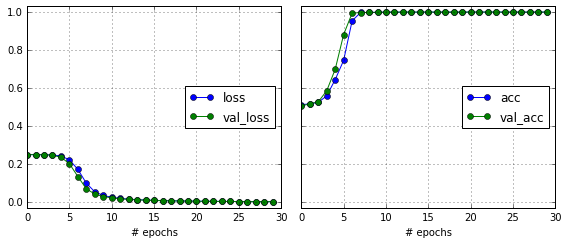

In [3]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(8, 3.5))
axes = axes.ravel()

for k, keys in enumerate([['loss', 'val_loss'], ['acc', 'val_acc']]):
    ax = axes[k]
    
    for key in keys:
        ax.plot(hist.history[key], 'o-', label=key)
    ax.grid()
    ax.legend(loc='center right')
    ax.set_ylim(-0.03, 1.03)
    ax.set_xlabel('# epochs')
plt.tight_layout()

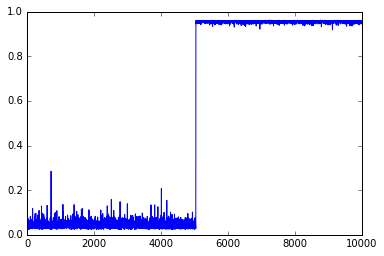

In [4]:
plt.plot(model.predict(train_xs[np.argsort(train_ys)]))

ref: http://colah.github.io/posts/2015-08-Understanding-LSTMs/

Since the input at each time step is only 1 dimension, so I used $w$ (scalar) instead of $W$ (matrix).

<img src="https://raw.githubusercontent.com/zyxue/sutton-barto-rl-exercises/master/supervised/neuron_networks/gru.png" width=600/>

Calculate gates:

\begin{align*}
r_t &= \sigma(w_r[h_{t-1}, x_t] + b_r) \\
z_t &= \sigma(w_z[h_{t-1}, x_t] + b_z) \\
\tilde{h}_t &= \tanh(w_h[r_t \odot h_{t-1}, x_t] + b_h) \\
h_t &= z_t \odot h_{t-1} + (1 - z_t) \odot \tilde{h}_t
\end{align*}

For the last equation, $(1 - z_t)$ and $z_t$ could be switched without affecting the results. I used the form  consistent with that in [Learning to Execute](https://arxiv.org/pdf/1410.4615.pdf) instead of http://colah.github.io/posts/2015-08-Understanding-LSTMs/, since the former appears to be consistent with the form implemented in Keras.

In [5]:
rnn.get_weights()

[array([[ 2.4769294, -2.1732652,  1.9603004]], dtype=float32),
 array([[-2.7047381 , -0.05110962,  1.569025  ]], dtype=float32),
 array([0.5982965, 1.7411941, 0.3563405], dtype=float32)]

In [6]:
# ref: https://github.com/keras-team/keras/blob/d035967a5d2795734c89a0a3c002f7eb5c34eff1/keras/layers/recurrent.py#L1296
kernel = np.array(rnn.get_weights()[:2])[:,0,:]
kernel

array([[ 2.4769294 , -2.1732652 ,  1.9603004 ],
       [-2.7047381 , -0.05110962,  1.569025  ]], dtype=float32)

In [7]:
w_z, w_r, w_h = kernel.T
b_z, b_r, b_h = rnn.get_weights()[-1]

In [8]:
print(w_z, b_z)
print(w_r, b_r)
print(w_h, b_h)

[ 2.4769294 -2.7047381] 0.5982965
[-2.1732652  -0.05110962] 1.7411941
[1.9603004 1.569025 ] 0.3563405


In [9]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[3.5899737] [-0.19562314]


In [10]:
rand_idx = np.random.choice(np.arange(train_xs.shape[0]), 4)
print(rand_idx)
for k, single_x in enumerate(train_xs[rand_idx]):
    h_prev = 0
    C_prev = 0

    hist = []
    for t in range(single_x.shape[0]):
        z_t = sigmoid(np.dot(w_z, [single_x[t][0], h_prev]) + b_z)
        r_t = sigmoid(np.dot(w_r, [single_x[t][0], h_prev]) + b_r)
        h_t_tilde = np.tanh(np.dot(w_h, [single_x[t][0], r_t * h_prev]) + b_h) # use B to mean \tilde{C}
        h_t = (z_t) * h_prev + (1 - z_t) * h_t_tilde

        hist.append([z_t, r_t, h_t_tilde, h_t])

        h_prev = h_t
    den_in = hist[-1][-1]
    out = sigmoid(den_in * d_w0 + d_b0)
    print(out, model.predict(np.array([single_x])))

[9758 1023  589 1995]
[0.95203435] [[0.952283]]
[0.06684057] [[0.04142882]]
[0.959427] [[0.958656]]
[0.05395984] [[0.03973615]]


The mannual process and model prediction are highly correlated, but still not the same...., in constrast to simpler SimpleRNN process in another notebook.

# Single x debugging and time step visualization

In [11]:
single_x = train_xs[5]
# single_x

In [12]:
h_prev = 0
C_prev = 0

hist = []
for t in range(single_x.shape[0]):
    z_t = sigmoid(np.dot(w_z, [single_x[t][0], h_prev]) + b_z)
    r_t = sigmoid(np.dot(w_r, [single_x[t][0], h_prev]) + b_r)
    h_t_tilde = np.tanh(np.dot(w_h, [single_x[t][0], r_t * h_prev]) + b_h) # use B to mean \tilde{C}
    h_t = (z_t) * h_prev + (1 - z_t) * h_t_tilde

    hist.append([z_t, r_t, h_t_tilde, h_t])

    h_prev = h_t

Copied the formulas here for easy reference:

\begin{align*}
r_t &= \sigma(w_r[h_{t-1}, x_t] + b_r) \\
z_t &= \sigma(w_z[h_{t-1}, x_t] + b_z) \\
\tilde{h}_t &= \tanh(w_h[r_t \odot h_{t-1}, x_t] + b_h) \\
h_t &= z_t \odot h_{t-1} + (1 - z_t) \odot \tilde{h}_t
\end{align*}

In [13]:
w_h[0]

1.9603004

In [14]:
b_h

0.3563405

In [15]:
w_h[0] + b_h

2.3166409

In [16]:
- w_h[0] + b_h

-1.6039599

In [17]:
np.tanh(w_h[0] * (1) + b_h)

0.980741649909103

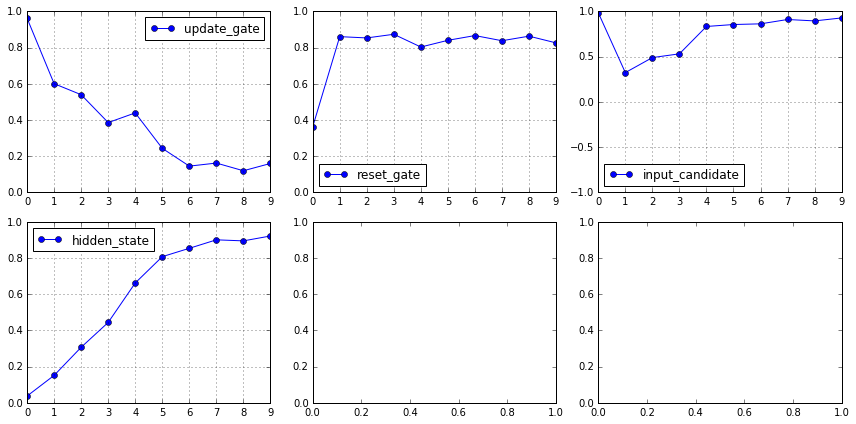

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), 
#                          sharex=True, sharey=True
                        )
axes = axes.ravel()

for k, i in enumerate([
    'update_gate', 'reset_gate', 'input_candidate', 'hidden_state'
]):
    ax = axes[k]
    ax.plot(np.array(hist)[:,k], 'o-', label=i)
    ax.legend(loc='best')
    ax.grid()
    
    if k in [0, 1, 3]:
        ax.set_ylim(0, 1)
    if k == 2:
        ax.set_ylim(-1, 1)

plt.tight_layout()

This shows that `update_gate` ($z_t$) is always zero, and `reset_gate` ($r_t$) is always one, so the above four equations effectively become

\begin{align*}
h_t &= \tilde{h}_t = \tanh(w_h[h_{t-1}, x_t] + b_h)
\end{align*}

**Insight**:

Since $x_t$ is mostly zero except at the very beginning, it could be mannually verified that this equation osscilate between 1 and -1. Hence if the beginning is one, then it ends with zero, vice versa.

The zigzag reminds me of tanh in vanilla RNN.

It would be interesting to see how the function adapts if the seq length vary within a dataset.

In [19]:
dense.get_weights()

[array([[3.5899737]], dtype=float32), array([-0.19562314], dtype=float32)]

In [20]:
# den_in = hist[-1][-1] # dense input
den_in = hist[-1][-1]

In [21]:
den_in

0.9226465005750767

In [22]:
d_w0 = dense.get_weights()[0][0]
d_b0 = dense.get_weights()[1]
print(d_w0, d_b0)

[3.5899737] [-0.19562314]


In [23]:
sigmoid(den_in * d_w0 + d_b0)

array([0.9575745], dtype=float32)

In [24]:
model.predict(np.array([single_x]))

array([[0.95706177]], dtype=float32)

Followed equations from [colah's blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), but there is always inconsistency.... 